In [3]:
!export PYTHONPATH="${PYTHONPATH}:~/sparse_coding_torch/"

In [4]:
cd ..

/home/xw384/sparse_coding_torch


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import argparse
import os
#from utils.load_data import load_bamc_data, load_bamc_clips
from feature_extraction.conv_sparse_model import ConvSparseLayer
from data_classifiers.small_data_classifier import SmallDataClassifier
import time
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, pairwise_distances
import random
from data_classifiers.pca import PCASparseActivations
import torchvision
from utils.video_loader import VideoGrayScaler, MinMaxScaler
from torchvision.datasets.video_utils import VideoClips
from sklearn.linear_model import LinearRegression

In [6]:
data = ["shared_data/YOLO_PL_Model_Results/clips/No_Sliding/Image_262499828648_clean"+str(i)+".mp4" for i in range(1050,1121)]

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1


frozen_sparse = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(5, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               lam=0.05,
                               max_activation_iter=200,
                               activation_lr=1e-1)

sparse_param = torch.load("sparse_checkpoint/sparse_conv3d_model-best.pt", map_location=device)
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
frozen_sparse.to(device)

predictive_model = torch.nn.DataParallel(SmallDataClassifier())
predictive_model.to(device)


checkpoint = torch.load("checkpoint/model-best_fold_1.pt", map_location=device)
predictive_model.load_state_dict(checkpoint['model_state_dict'])

transform = torchvision.transforms.Compose(
[VideoGrayScaler(),
 MinMaxScaler(0, 255),
 torchvision.transforms.Normalize((0.2592,), (0.1251,)),
 torchvision.transforms.CenterCrop((100, 200))
])


vc = VideoClips(   data,
                   clip_length_in_frames=5,
                   frame_rate=20,
                   frames_between_clips=1)

clip_predictions = []
max_weights = []
min_weights = []
all_weights_1pertu = []
for i in tqdm(range(vc.num_clips())):
    clip, _, _, _ = vc.get_clip(i)
    clip = clip.swapaxes(1, 3).swapaxes(0, 1).swapaxes(2, 3).to(torch.float)
    clip = transform(clip)

    with torch.no_grad():
        clip = clip.unsqueeze(0).to(device)
        u_init = torch.zeros([1, frozen_sparse.out_channels] + frozen_sparse.get_output_shape(clip)).to(device)
        activations, _ = frozen_sparse(clip, u_init)

        # Note that you can get activations here
        pred, activations = predictive_model(activations)

        clip_predictions.append(torch.nn.Sigmoid()(pred).round().detach().cpu().flatten().to(torch.long))
        
        zero_activation = torch.zeros(1,100,200).to(device)
        
        perturbations = []
        predictions = []
        for i in range(64):
            x = np.ones(64)
            x[i] = 0
            perturbations.append(x.tolist())

            perturbation = torch.clone(activations)
            perturbation[0][i] = zero_activation
            preds, _ = predictive_model(perturbation)
            predictions.append(preds.detach().cpu().numpy()[0][0])
            
      
        original_image = np.ones(64).reshape(1, -1) 
        distances = pairwise_distances(perturbations, original_image, metric='cosine').ravel()
        #print(distances)
        print("\n")
        ### Using a kernel function to convert cosine distance to a value between 0 to 1 as a weight
        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
        #print(weights)
        
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)

        ### Obtaining the super-pixel in the image representing how strong the effect of super-pixel is
        coeff = simpler_model.coef_
        
        
        '''
        num_top_features = 4
        top_features = np.argsort(coeff)[-num_top_features:]
        max_weights.append(top_features)  
        
      
        num_bottom_features = 4
        bottom_features = np.argsort(coeff)[:num_bottom_features]
        min_weights.append(bottom_features) 
        '''

        all_weights_1pertu.append(np.argsort(coeff))  




  0%|          | 0/5 [00:00<?, ?it/s]

  1%|█▏                                                                                  | 1/71 [00:00<01:08,  1.02it/s]

  3%|██▎                                                                                 | 2/71 [00:01<01:02,  1.11it/s]

  4%|███▌                                                                                | 3/71 [00:02<01:03,  1.07it/s]

  6%|████▋                                                                               | 4/71 [00:03<01:03,  1.05it/s]

  7%|█████▉                                                                              | 5/71 [00:04<01:03,  1.04it/s]

  8%|███████                                                                             | 6/71 [00:05<01:02,  1.04it/s]

 10%|████████▎                                                                           | 7/71 [00:06<01:01,  1.03it/s]

 11%|█████████▍                                                                          | 8/71 [00:07<01:01,  1.03it/s]

 13%|██████████▋                                                                         | 9/71 [00:08<01:00,  1.03it/s]

 14%|███████████▋                                                                       | 10/71 [00:09<00:59,  1.03it/s]

 15%|████████████▊                                                                      | 11/71 [00:10<00:58,  1.03it/s]

 17%|██████████████                                                                     | 12/71 [00:11<00:57,  1.02it/s]

 18%|███████████████▏                                                                   | 13/71 [00:12<00:56,  1.02it/s]

 20%|████████████████▎                                                                  | 14/71 [00:13<00:55,  1.02it/s]

 21%|█████████████████▌                                                                 | 15/71 [00:14<00:54,  1.02it/s]

 23%|██████████████████▋                                                                | 16/71 [00:15<00:53,  1.02it/s]

 24%|███████████████████▊                                                               | 17/71 [00:16<00:53,  1.02it/s]

 25%|█████████████████████                                                              | 18/71 [00:17<00:52,  1.02it/s]

 27%|██████████████████████▏                                                            | 19/71 [00:18<00:51,  1.01it/s]

 28%|███████████████████████▍                                                           | 20/71 [00:19<00:50,  1.01it/s]

 30%|████████████████████████▌                                                          | 21/71 [00:20<00:49,  1.01it/s]

 31%|█████████████████████████▋                                                         | 22/71 [00:21<00:48,  1.01it/s]

 32%|██████████████████████████▉                                                        | 23/71 [00:22<00:47,  1.01it/s]

 34%|████████████████████████████                                                       | 24/71 [00:23<00:46,  1.01it/s]

 35%|█████████████████████████████▏                                                     | 25/71 [00:24<00:45,  1.01it/s]

 37%|██████████████████████████████▍                                                    | 26/71 [00:25<00:44,  1.00it/s]

 38%|███████████████████████████████▌                                                   | 27/71 [00:26<00:43,  1.00it/s]

 39%|████████████████████████████████▋                                                  | 28/71 [00:27<00:42,  1.01it/s]

 41%|█████████████████████████████████▉                                                 | 29/71 [00:28<00:41,  1.01it/s]

 42%|███████████████████████████████████                                                | 30/71 [00:29<00:40,  1.01it/s]

 44%|████████████████████████████████████▏                                              | 31/71 [00:30<00:39,  1.01it/s]

 45%|█████████████████████████████████████▍                                             | 32/71 [00:31<00:38,  1.01it/s]

 46%|██████████████████████████████████████▌                                            | 33/71 [00:32<00:37,  1.01it/s]

 48%|███████████████████████████████████████▋                                           | 34/71 [00:33<00:36,  1.00it/s]

 49%|████████████████████████████████████████▉                                          | 35/71 [00:34<00:35,  1.00it/s]

 51%|██████████████████████████████████████████                                         | 36/71 [00:35<00:34,  1.00it/s]

 52%|███████████████████████████████████████████▎                                       | 37/71 [00:36<00:33,  1.00it/s]

 54%|████████████████████████████████████████████▍                                      | 38/71 [00:37<00:32,  1.00it/s]

 55%|█████████████████████████████████████████████▌                                     | 39/71 [00:38<00:32,  1.00s/it]

 56%|██████████████████████████████████████████████▊                                    | 40/71 [00:39<00:31,  1.00s/it]

 58%|███████████████████████████████████████████████▉                                   | 41/71 [00:40<00:30,  1.00s/it]

 59%|█████████████████████████████████████████████████                                  | 42/71 [00:41<00:29,  1.00s/it]

 61%|██████████████████████████████████████████████████▎                                | 43/71 [00:42<00:28,  1.00s/it]

 62%|███████████████████████████████████████████████████▍                               | 44/71 [00:43<00:27,  1.00s/it]

 63%|████████████████████████████████████████████████████▌                              | 45/71 [00:44<00:26,  1.00s/it]

 65%|█████████████████████████████████████████████████████▊                             | 46/71 [00:45<00:25,  1.00s/it]

 66%|██████████████████████████████████████████████████████▉                            | 47/71 [00:46<00:24,  1.00s/it]

 68%|████████████████████████████████████████████████████████                           | 48/71 [00:47<00:23,  1.00s/it]

 69%|█████████████████████████████████████████████████████████▎                         | 49/71 [00:48<00:22,  1.00s/it]

 70%|██████████████████████████████████████████████████████████▍                        | 50/71 [00:49<00:21,  1.00s/it]

 72%|███████████████████████████████████████████████████████████▌                       | 51/71 [00:50<00:20,  1.01s/it]

 73%|████████████████████████████████████████████████████████████▊                      | 52/71 [00:51<00:19,  1.00s/it]

 75%|█████████████████████████████████████████████████████████████▉                     | 53/71 [00:52<00:18,  1.01s/it]

 76%|███████████████████████████████████████████████████████████████▏                   | 54/71 [00:53<00:17,  1.01s/it]

 77%|████████████████████████████████████████████████████████████████▎                  | 55/71 [00:54<00:16,  1.01s/it]

 79%|█████████████████████████████████████████████████████████████████▍                 | 56/71 [00:55<00:14,  1.03it/s]

 80%|██████████████████████████████████████████████████████████████████▋                | 57/71 [00:56<00:13,  1.02it/s]

 82%|███████████████████████████████████████████████████████████████████▊               | 58/71 [00:57<00:12,  1.01it/s]

 83%|████████████████████████████████████████████████████████████████████▉              | 59/71 [00:58<00:11,  1.00it/s]

 85%|██████████████████████████████████████████████████████████████████████▏            | 60/71 [00:59<00:11,  1.00s/it]

 86%|███████████████████████████████████████████████████████████████████████▎           | 61/71 [01:00<00:10,  1.01s/it]

 87%|████████████████████████████████████████████████████████████████████████▍          | 62/71 [01:01<00:09,  1.01s/it]

 89%|█████████████████████████████████████████████████████████████████████████▋         | 63/71 [01:02<00:08,  1.01s/it]

 90%|██████████████████████████████████████████████████████████████████████████▊        | 64/71 [01:03<00:07,  1.01s/it]

 92%|███████████████████████████████████████████████████████████████████████████▉       | 65/71 [01:04<00:06,  1.01s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▏     | 66/71 [01:05<00:05,  1.02s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▎    | 67/71 [01:06<00:04,  1.02s/it]

 96%|███████████████████████████████████████████████████████████████████████████████▍   | 68/71 [01:07<00:03,  1.02s/it]

 97%|████████████████████████████████████████████████████████████████████████████████▋  | 69/71 [01:08<00:02,  1.02s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 70/71 [01:09<00:01,  1.02s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [01:10<00:00,  1.01it/s]

In [88]:
wrong = [i+1 for i,x in enumerate(clip_predictions) if x ==0]
right = [i+1 for i,x in enumerate(clip_predictions) if x ==1]

In [90]:
wrong_weights_1pertu = np.array(all_weights_1pertu)[wrong,:]
right_weights_1pertu = np.array(all_weights_1pertu)[right,:]

In [91]:
wrong_weights_1pertu 

array([[61, 36, 62, 52, 20, 15,  1,  6, 40, 22, 32, 44, 41, 29, 16, 17,
        58, 30,  3,  2, 56, 27, 13, 42, 46, 38, 10, 49, 50, 55, 35,  0,
        33,  7, 39,  4,  5, 57, 14, 18,  8, 48, 11, 28, 23, 37, 34, 54,
        51, 60, 26, 53, 47, 19, 25, 59, 43,  9, 21, 45, 24, 63, 31, 12],
       [21, 20, 24, 48, 56, 25, 27,  0, 28, 54, 38, 23, 42, 44, 40, 36,
        15, 37, 58,  4, 57, 43, 55, 14, 30, 51, 17, 35, 50, 13, 39,  2,
        41,  3, 26, 61, 63, 62, 47,  7, 33, 52, 49,  5,  6,  8, 59, 34,
        22, 60, 10, 45,  1, 31, 29, 46, 11, 32, 19, 18, 12,  9, 16, 53],
       [21, 42, 33,  8, 13, 45, 32, 11, 62, 24, 20,  0, 12,  9, 36, 39,
        25, 54, 53, 16, 52, 56, 34, 27, 41, 61, 31, 58, 63, 23, 43, 26,
        38,  6, 48,  7, 47, 19, 40, 14, 60, 22, 15, 29, 46, 55, 17,  4,
        18,  2, 57,  3, 49,  1, 30, 10, 28, 50, 35, 44, 37, 51,  5, 59],
       [27, 21, 47, 24, 59, 14,  1, 33, 39, 48, 53, 13, 18, 34, 31, 30,
        60, 22, 23, 51,  4, 38, 17, 56,  0,  2, 11,  8,  3, 4

In [97]:
right_weights_1pertu 

array([[56, 51, 60, ..., 16, 42, 50],
       [ 8, 30, 51, ...,  0,  4, 36],
       [ 2, 43, 60, ..., 47, 26, 61],
       ...,
       [27, 57, 35, ..., 36,  8, 59],
       [22, 24, 16, ..., 37, 59, 31],
       [58, 59, 34, ..., 28, 16, 62]])

In [103]:
np.savetxt('wrong_weights_1pertu.csv', wrong_weights_1pertu, delimiter=',', fmt = '%f')
np.savetxt('right_weights_1pertu.csv', right_weights_1pertu, delimiter=',', fmt = '%f')

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1
clip_predictions = []

frozen_sparse = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(5, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               lam=0.05,
                               max_activation_iter=200,
                               activation_lr=1e-1)

sparse_param = torch.load("sparse_checkpoint/sparse_conv3d_model-best.pt", map_location=device)
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
frozen_sparse.to(device)

predictive_model = torch.nn.DataParallel(SmallDataClassifier())
predictive_model.to(device)


checkpoint = torch.load("checkpoint/model-best_fold_1.pt", map_location=device)
predictive_model.load_state_dict(checkpoint['model_state_dict'])

transform = torchvision.transforms.Compose(
[VideoGrayScaler(),
 MinMaxScaler(0, 255),
 torchvision.transforms.Normalize((0.2592,), (0.1251,)),
 torchvision.transforms.CenterCrop((100, 200))
])


vc = VideoClips(   data,
                   clip_length_in_frames=5,
                   frame_rate=20,
                   frames_between_clips=1)

clip_predictions_2pertu = []
max_weights = []
min_weights = []
all_weights_2pertu = []
for i in tqdm(range(vc.num_clips())):
    clip, _, _, _ = vc.get_clip(i)
    clip = clip.swapaxes(1, 3).swapaxes(0, 1).swapaxes(2, 3).to(torch.float)
    clip = transform(clip)

    with torch.no_grad():
        clip = clip.unsqueeze(0).to(device)
        u_init = torch.zeros([1, frozen_sparse.out_channels] + frozen_sparse.get_output_shape(clip)).to(device)
        activations, _ = frozen_sparse(clip, u_init)

        # Note that you can get activations here
        pred, activations = predictive_model(activations)

        clip_predictions.append(torch.nn.Sigmoid()(pred).round().detach().cpu().flatten().to(torch.long))
        
        zero_activation = torch.zeros(1,100,200).to(device)
        
        perturbations = []
        predictions = []
        
        for i in range(64):
            for k in range(i+1,64):
                x = np.ones(64)
                x[i] = 0
                x[k] = 0
                perturbations.append(x.tolist())

                perturbation = torch.clone(activations)
                perturbation[0][i] = zero_activation
                perturbation[0][k] = zero_activation
                preds, _ = predictive_model(perturbation)
                predictions.append(preds.detach().cpu().numpy()[0][0])
                
            
      
        original_image = np.ones(64).reshape(1, -1) 
        distances = pairwise_distances(perturbations, original_image, metric='cosine').ravel()
        #print(distances)
        print("\n")
        ### Using a kernel function to convert cosine distance to a [i+1 for i,x in enumerate(clip_predictions) if x ==0]value between 0 to 1 as a weight
        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
        #print(weights)
        
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)

        ### Obtaining the super-pixel in the image representing how strong the effect of super-pixel is
        coeff = simpler_model.coef_
        
        '''
        num_top_features = 4
        top_features = np.argsort(coeff)[-num_top_features:]
        max_weights.append(top_features)  
        
        num_bottom_features = 4
        bottom_features = np.argsort(coeff)[:num_bottom_features]
        min_weights.append(bottom_features) 
        '''
        
        all_weights_2pertu.append(np.argsort(coeff)) 
    

        




  0%|          | 0/5 [00:00<?, ?it/s]

  1%|█▏                                                                                  | 1/71 [00:04<05:25,  4.65s/it]

  3%|██▎                                                                                 | 2/71 [00:09<05:22,  4.67s/it]

  4%|███▌                                                                                | 3/71 [00:14<05:21,  4.73s/it]

  6%|████▋                                                                               | 4/71 [00:18<05:17,  4.74s/it]

  7%|█████▉                                                                              | 5/71 [00:23<05:14,  4.76s/it]

  8%|███████                                                                             | 6/71 [00:28<05:10,  4.78s/it]

 10%|████████▎                                                                           | 7/71 [00:33<05:05,  4.78s/it]

 11%|█████████▍                                                                          | 8/71 [00:37<04:58,  4.74s/it]

 13%|██████████▋                                                                         | 9/71 [00:42<04:54,  4.75s/it]

 14%|███████████▋                                                                       | 10/71 [00:47<04:49,  4.75s/it]

 15%|████████████▊                                                                      | 11/71 [00:52<04:43,  4.73s/it]

 17%|██████████████                                                                     | 12/71 [00:56<04:40,  4.75s/it]

 18%|███████████████▏                                                                   | 13/71 [01:01<04:39,  4.82s/it]

 20%|████████████████▎                                                                  | 14/71 [01:06<04:35,  4.84s/it]

 21%|█████████████████▌                                                                 | 15/71 [01:11<04:31,  4.84s/it]

 23%|██████████████████▋                                                                | 16/71 [01:16<04:25,  4.83s/it]

 24%|███████████████████▊                                                               | 17/71 [01:21<04:20,  4.82s/it]

 25%|█████████████████████                                                              | 18/71 [01:26<04:14,  4.81s/it]

 27%|██████████████████████▏                                                            | 19/71 [01:31<04:12,  4.86s/it]

 28%|███████████████████████▍                                                           | 20/71 [01:35<04:08,  4.87s/it]

 30%|████████████████████████▌                                                          | 21/71 [01:40<04:03,  4.87s/it]

 31%|█████████████████████████▋                                                         | 22/71 [01:45<03:56,  4.83s/it]

 32%|██████████████████████████▉                                                        | 23/71 [01:50<03:50,  4.80s/it]

 34%|████████████████████████████                                                       | 24/71 [01:54<03:44,  4.77s/it]

 35%|█████████████████████████████▏                                                     | 25/71 [01:59<03:38,  4.76s/it]

 37%|██████████████████████████████▍                                                    | 26/71 [02:04<03:33,  4.74s/it]

 38%|███████████████████████████████▌                                                   | 27/71 [02:09<03:28,  4.74s/it]

 39%|████████████████████████████████▋                                                  | 28/71 [02:13<03:24,  4.74s/it]

 41%|█████████████████████████████████▉                                                 | 29/71 [02:18<03:18,  4.74s/it]

 42%|███████████████████████████████████                                                | 30/71 [02:23<03:15,  4.77s/it]

 44%|████████████████████████████████████▏                                              | 31/71 [02:28<03:13,  4.83s/it]

 45%|█████████████████████████████████████▍                                             | 32/71 [02:33<03:07,  4.81s/it]

 46%|██████████████████████████████████████▌                                            | 33/71 [02:38<03:03,  4.84s/it]

 48%|███████████████████████████████████████▋                                           | 34/71 [02:42<02:58,  4.83s/it]

 49%|████████████████████████████████████████▉                                          | 35/71 [02:47<02:54,  4.85s/it]

 51%|██████████████████████████████████████████                                         | 36/71 [02:52<02:50,  4.87s/it]

 52%|███████████████████████████████████████████▎                                       | 37/71 [02:57<02:45,  4.86s/it]

 54%|████████████████████████████████████████████▍                                      | 38/71 [03:02<02:40,  4.87s/it]

 55%|█████████████████████████████████████████████▌                                     | 39/71 [03:07<02:35,  4.86s/it]

 56%|██████████████████████████████████████████████▊                                    | 40/71 [03:12<02:31,  4.88s/it]

 58%|███████████████████████████████████████████████▉                                   | 41/71 [03:16<02:25,  4.85s/it]

 59%|█████████████████████████████████████████████████                                  | 42/71 [03:21<02:20,  4.86s/it]

 61%|██████████████████████████████████████████████████▎                                | 43/71 [03:26<02:15,  4.84s/it]

 62%|███████████████████████████████████████████████████▍                               | 44/71 [03:31<02:09,  4.81s/it]

 63%|████████████████████████████████████████████████████▌                              | 45/71 [03:36<02:05,  4.81s/it]

 65%|█████████████████████████████████████████████████████▊                             | 46/71 [03:40<01:59,  4.79s/it]

 66%|██████████████████████████████████████████████████████▉                            | 47/71 [03:45<01:54,  4.79s/it]

 68%|████████████████████████████████████████████████████████                           | 48/71 [03:50<01:49,  4.76s/it]

 69%|█████████████████████████████████████████████████████████▎                         | 49/71 [03:55<01:44,  4.77s/it]

 70%|██████████████████████████████████████████████████████████▍                        | 50/71 [04:00<01:40,  4.79s/it]

 72%|███████████████████████████████████████████████████████████▌                       | 51/71 [04:04<01:35,  4.79s/it]

 73%|████████████████████████████████████████████████████████████▊                      | 52/71 [04:09<01:30,  4.76s/it]

 75%|█████████████████████████████████████████████████████████████▉                     | 53/71 [04:14<01:25,  4.77s/it]

 76%|███████████████████████████████████████████████████████████████▏                   | 54/71 [04:19<01:20,  4.74s/it]

 77%|████████████████████████████████████████████████████████████████▎                  | 55/71 [04:23<01:16,  4.76s/it]

 79%|█████████████████████████████████████████████████████████████████▍                 | 56/71 [04:28<01:11,  4.74s/it]

 80%|██████████████████████████████████████████████████████████████████▋                | 57/71 [04:33<01:07,  4.79s/it]

 82%|███████████████████████████████████████████████████████████████████▊               | 58/71 [04:38<01:02,  4.77s/it]

 83%|████████████████████████████████████████████████████████████████████▉              | 59/71 [04:42<00:57,  4.79s/it]

 85%|██████████████████████████████████████████████████████████████████████▏            | 60/71 [04:47<00:52,  4.79s/it]

 86%|███████████████████████████████████████████████████████████████████████▎           | 61/71 [04:52<00:47,  4.78s/it]

 87%|████████████████████████████████████████████████████████████████████████▍          | 62/71 [04:57<00:42,  4.77s/it]

 89%|█████████████████████████████████████████████████████████████████████████▋         | 63/71 [05:02<00:38,  4.83s/it]

 90%|██████████████████████████████████████████████████████████████████████████▊        | 64/71 [05:07<00:33,  4.84s/it]

 92%|███████████████████████████████████████████████████████████████████████████▉       | 65/71 [05:11<00:28,  4.82s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▏     | 66/71 [05:16<00:24,  4.87s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▎    | 67/71 [05:21<00:19,  4.84s/it]

 96%|███████████████████████████████████████████████████████████████████████████████▍   | 68/71 [05:26<00:14,  4.83s/it]

 97%|████████████████████████████████████████████████████████████████████████████████▋  | 69/71 [05:31<00:09,  4.80s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 70/71 [05:35<00:04,  4.79s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [05:40<00:00,  4.80s/it]

In [110]:
clip_predictions = clip_predictions[71:]
wrong = [i for i,x in enumerate(clip_predictions) if x ==0]
right = [i for i,x in enumerate(clip_predictions) if x ==1]

In [111]:
len(clip_predictions)

71

In [112]:
wrong_weights_2pertu = np.array(all_weights_2pertu)[wrong,:]
right_weights_2pertu = np.array(all_weights_2pertu)[right,:]

In [114]:
np.savetxt('wrong_weights_2pertu.csv', wrong_weights_2pertu, delimiter=',', fmt = '%f')
np.savetxt('right_weights_2pertu.csv', right_weights_2pertu, delimiter=',', fmt = '%f')

In [127]:
coeff

array([ 2.4383032 , -5.03257325, -1.82085231, -0.50072339,  3.05181393,
       -0.38226131, -0.91905883,  3.65858838, -3.54074338, -1.89540675,
        0.5008516 ,  2.14088914, -5.37578538, -3.18958095,  2.32412908,
       -1.55996755, -4.55806115,  1.54241893, -1.22021773, -0.49262622,
        2.39615581,  3.24789116, -0.7029815 , -0.3361235 , -0.41413978,
       -1.04378655, -0.62209371, -0.79905084,  1.49898025, -2.24249652,
        2.48445293,  1.24539921,  3.38374695, -1.25296309, -2.34359124,
       -0.20047572,  3.68662438,  0.33229348,  2.25839779,  1.22963688,
       -0.02078298, -3.84390023,  0.49401471, -1.61230567, -0.02909854,
       -0.71559051,  2.821318  ,  1.97254488, -2.78049186,  1.94211909,
        1.34005615,  0.85105249,  0.59366509,  0.66898343, -2.07461789,
        1.2911112 ,  2.12783262,  0.29181096, -0.66882136, -1.49146178,
        0.9255192 , -2.62245849,  0.76512215,  2.60149333])

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1


frozen_sparse = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(5, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               lam=0.05,
                               max_activation_iter=200,
                               activation_lr=1e-1)

sparse_param = torch.load("sparse_checkpoint/sparse_conv3d_model-best.pt", map_location=device)
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
frozen_sparse.to(device)

predictive_model = torch.nn.DataParallel(SmallDataClassifier())
predictive_model.to(device)


checkpoint = torch.load("checkpoint/model-best_fold_1.pt", map_location=device)
predictive_model.load_state_dict(checkpoint['model_state_dict'])

transform = torchvision.transforms.Compose(
[VideoGrayScaler(),
 MinMaxScaler(0, 255),
 torchvision.transforms.Normalize((0.2592,), (0.1251,)),
 torchvision.transforms.CenterCrop((100, 200))
])


vc = VideoClips(   data,
                   clip_length_in_frames=5,
                   frame_rate=20,
                   frames_between_clips=1)


clip_predictions = []
max_weights = []
min_weights = []
all_weights_5pertu = []
for i in tqdm(range(vc.num_clips())):
    clip, _, _, _ = vc.get_clip(i)
    clip = clip.swapaxes(1, 3).swapaxes(0, 1).swapaxes(2, 3).to(torch.float)
    clip = transform(clip)

    
    
    with torch.no_grad():
        clip = clip.unsqueeze(0).to(device)
        u_init = torch.zeros([1, frozen_sparse.out_channels] + frozen_sparse.get_output_shape(clip)).to(device)
        activations, _ = frozen_sparse(clip, u_init)

        # Note that you can get activations here
        pred, activations = predictive_model(activations)

        clip_predictions.append(torch.nn.Sigmoid()(pred).round().detach().cpu().flatten().to(torch.long))
        
        zero_activation = torch.zeros(1,100,200).to(device)
        
        perturbations = []
        predictions = []
        
       
        for i in range(5000):
            indexs = random.sample(range(64), 5) 
            x = np.ones(64)
            perturbation = torch.clone(activations)         
            for index in indexs:
                x[index] = 0
                perturbation[0][index] = zero_activation

            perturbations.append(x.tolist())
            preds, _ = predictive_model(perturbation)
            predictions.append(preds.detach().cpu().numpy()[0][0])

      
        original_image = np.ones(64).reshape(1, -1) 
        distances = pairwise_distances(perturbations, original_image, metric='cosine').ravel()
        #print(distances)
        print("\n")
        ### Using a kernel function to convert cosine distance to a value between 0 to 1 as a weight
        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
        #print(weights)
        
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)

        ### Obtaining the super-pixel in the image representing how strong the effect of super-pixel is
        coeff = simpler_model.coef_
        
        
        '''
        num_top_features = 4
        top_features = np.argsort(coeff)[-num_top_features:]
        max_weights.append(top_features)  
        
      
        num_bottom_features = 4
        bottom_features = np.argsort(coeff)[:num_bottom_features]
        min_weights.append(bottom_features) 
        '''

        all_weights_5pertu.append(np.argsort(coeff))  

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|█▏                                                                                  | 1/71 [00:10<12:25, 10.65s/it]

  3%|██▎                                                                                 | 2/71 [00:21<12:12, 10.62s/it]

  4%|███▌                                                                                | 3/71 [00:31<12:03, 10.64s/it]

  6%|████▋                                                                               | 4/71 [00:42<11:51, 10.61s/it]

  7%|█████▉                                                                              | 5/71 [00:53<11:41, 10.62s/it]

  8%|███████                                                                             | 6/71 [01:03<11:32, 10.65s/it]

 10%|████████▎                                                                           | 7/71 [01:14<11:24, 10.69s/it]

 11%|█████████▍                                                                          | 8/71 [01:25<11:17, 10.76s/it]

 13%|██████████▋                                                                         | 9/71 [01:36<11:08, 10.79s/it]

 14%|███████████▋                                                                       | 10/71 [01:47<10:59, 10.81s/it]

 15%|████████████▊                                                                      | 11/71 [01:58<10:49, 10.82s/it]

 17%|██████████████                                                                     | 12/71 [02:08<10:38, 10.82s/it]

 18%|███████████████▏                                                                   | 13/71 [02:19<10:27, 10.82s/it]

 20%|████████████████▎                                                                  | 14/71 [02:30<10:18, 10.85s/it]

 21%|█████████████████▌                                                                 | 15/71 [02:41<10:07, 10.84s/it]

 23%|██████████████████▋                                                                | 16/71 [02:52<09:55, 10.82s/it]

 24%|███████████████████▊                                                               | 17/71 [03:03<09:48, 10.90s/it]

 25%|█████████████████████                                                              | 18/71 [03:14<09:41, 10.97s/it]

 27%|██████████████████████▏                                                            | 19/71 [03:25<09:34, 11.04s/it]

 28%|███████████████████████▍                                                           | 20/71 [03:36<09:19, 10.97s/it]

 30%|████████████████████████▌                                                          | 21/71 [03:47<09:07, 10.95s/it]

 31%|█████████████████████████▋                                                         | 22/71 [03:58<08:57, 10.98s/it]

 32%|██████████████████████████▉                                                        | 23/71 [04:09<08:47, 10.99s/it]

 34%|████████████████████████████                                                       | 24/71 [04:20<08:36, 10.99s/it]

 35%|█████████████████████████████▏                                                     | 25/71 [04:31<08:26, 11.01s/it]

 37%|██████████████████████████████▍                                                    | 26/71 [04:42<08:17, 11.06s/it]

 38%|███████████████████████████████▌                                                   | 27/71 [04:53<08:01, 10.94s/it]

 39%|████████████████████████████████▋                                                  | 28/71 [05:04<07:52, 11.00s/it]

 41%|█████████████████████████████████▉                                                 | 29/71 [05:15<07:40, 10.97s/it]

 42%|███████████████████████████████████                                                | 30/71 [05:26<07:30, 10.98s/it]

 44%|████████████████████████████████████▏                                              | 31/71 [05:37<07:15, 10.89s/it]

 45%|█████████████████████████████████████▍                                             | 32/71 [05:47<07:01, 10.81s/it]

 46%|██████████████████████████████████████▌                                            | 33/71 [05:58<06:48, 10.75s/it]

 48%|███████████████████████████████████████▋                                           | 34/71 [06:09<06:37, 10.76s/it]

 49%|████████████████████████████████████████▉                                          | 35/71 [06:19<06:26, 10.74s/it]

 51%|██████████████████████████████████████████                                         | 36/71 [06:30<06:15, 10.74s/it]

 52%|███████████████████████████████████████████▎                                       | 37/71 [06:41<06:06, 10.78s/it]

 54%|████████████████████████████████████████████▍                                      | 38/71 [06:52<05:59, 10.88s/it]

 55%|█████████████████████████████████████████████▌                                     | 39/71 [07:03<05:48, 10.88s/it]

 56%|██████████████████████████████████████████████▊                                    | 40/71 [07:14<05:37, 10.88s/it]

 58%|███████████████████████████████████████████████▉                                   | 41/71 [07:25<05:25, 10.87s/it]

 59%|█████████████████████████████████████████████████                                  | 42/71 [07:35<05:14, 10.86s/it]

 61%|██████████████████████████████████████████████████▎                                | 43/71 [07:46<05:04, 10.86s/it]

 62%|███████████████████████████████████████████████████▍                               | 44/71 [07:57<04:53, 10.86s/it]

 63%|████████████████████████████████████████████████████▌                              | 45/71 [08:08<04:43, 10.89s/it]

 65%|█████████████████████████████████████████████████████▊                             | 46/71 [08:19<04:33, 10.92s/it]

 66%|██████████████████████████████████████████████████████▉                            | 47/71 [08:30<04:23, 10.97s/it]

 68%|████████████████████████████████████████████████████████                           | 48/71 [08:41<04:12, 10.97s/it]

 69%|█████████████████████████████████████████████████████████▎                         | 49/71 [08:53<04:04, 11.12s/it]

 70%|██████████████████████████████████████████████████████████▍                        | 50/71 [09:04<03:52, 11.07s/it]

 72%|███████████████████████████████████████████████████████████▌                       | 51/71 [09:14<03:39, 10.96s/it]

 73%|████████████████████████████████████████████████████████████▊                      | 52/71 [09:26<03:30, 11.06s/it]

 75%|█████████████████████████████████████████████████████████████▉                     | 53/71 [09:37<03:18, 11.04s/it]

 76%|███████████████████████████████████████████████████████████████▏                   | 54/71 [09:47<03:06, 10.95s/it]

 77%|████████████████████████████████████████████████████████████████▎                  | 55/71 [09:58<02:54, 10.92s/it]

 79%|█████████████████████████████████████████████████████████████████▍                 | 56/71 [10:09<02:43, 10.92s/it]

 80%|██████████████████████████████████████████████████████████████████▋                | 57/71 [10:20<02:33, 10.93s/it]

 82%|███████████████████████████████████████████████████████████████████▊               | 58/71 [10:32<02:26, 11.24s/it]

 83%|████████████████████████████████████████████████████████████████████▉              | 59/71 [10:43<02:13, 11.13s/it]

 85%|██████████████████████████████████████████████████████████████████████▏            | 60/71 [10:54<02:01, 11.04s/it]

 86%|███████████████████████████████████████████████████████████████████████▎           | 61/71 [11:05<01:50, 11.00s/it]

 87%|████████████████████████████████████████████████████████████████████████▍          | 62/71 [11:15<01:38, 10.95s/it]

 89%|█████████████████████████████████████████████████████████████████████████▋         | 63/71 [11:26<01:26, 10.86s/it]

 90%|██████████████████████████████████████████████████████████████████████████▊        | 64/71 [11:37<01:15, 10.81s/it]

 92%|███████████████████████████████████████████████████████████████████████████▉       | 65/71 [11:47<01:04, 10.77s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▏     | 66/71 [11:58<00:53, 10.79s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▎    | 67/71 [12:09<00:43, 10.81s/it]

 96%|███████████████████████████████████████████████████████████████████████████████▍   | 68/71 [12:20<00:32, 10.80s/it]

 97%|████████████████████████████████████████████████████████████████████████████████▋  | 69/71 [12:31<00:21, 10.77s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 70/71 [12:42<00:10, 10.94s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [12:53<00:00, 10.89s/it]

In [35]:
wrong = [i for i,x in enumerate(clip_predictions) if x ==0]
right = [i for i,x in enumerate(clip_predictions) if x ==1]

In [36]:
wrong_weights_5pertu = np.array(all_weights_5pertu)[wrong,:]
right_weights_5pertu = np.array(all_weights_5pertu)[right,:]

[]

In [37]:
np.savetxt('wrong_weights_5pertu.csv', wrong_weights_5pertu, delimiter=',', fmt = '%f')
np.savetxt('right_weights_5pertu.csv', right_weights_5pertu, delimiter=',', fmt = '%f')

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1


frozen_sparse = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(5, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               lam=0.05,
                               max_activation_iter=200,
                               activation_lr=1e-1)

sparse_param = torch.load("sparse_checkpoint/sparse_conv3d_model-best.pt", map_location=device)
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
frozen_sparse.to(device)

predictive_model = torch.nn.DataParallel(SmallDataClassifier())
predictive_model.to(device)


checkpoint = torch.load("checkpoint/model-best_fold_1.pt", map_location=device)
predictive_model.load_state_dict(checkpoint['model_state_dict'])

transform = torchvision.transforms.Compose(
[VideoGrayScaler(),
 MinMaxScaler(0, 255),
 torchvision.transforms.Normalize((0.2592,), (0.1251,)),
 torchvision.transforms.CenterCrop((100, 200))
])


vc = VideoClips(   data,
                   clip_length_in_frames=5,
                   frame_rate=20,
                   frames_between_clips=1)


clip_predictions = []
max_weights = []
min_weights = []
all_weights_10pertu = []
for i in tqdm(range(vc.num_clips())):
    clip, _, _, _ = vc.get_clip(i)
    clip = clip.swapaxes(1, 3).swapaxes(0, 1).swapaxes(2, 3).to(torch.float)
    clip = transform(clip)

    
    
    with torch.no_grad():
        clip = clip.unsqueeze(0).to(device)
        u_init = torch.zeros([1, frozen_sparse.out_channels] + frozen_sparse.get_output_shape(clip)).to(device)
        activations, _ = frozen_sparse(clip, u_init)

        # Note that you can get activations here
        pred, activations = predictive_model(activations)

        clip_predictions.append(torch.nn.Sigmoid()(pred).round().detach().cpu().flatten().to(torch.long))
        
        zero_activation = torch.zeros(1,100,200).to(device)
        
        perturbations = []
        predictions = []
        
       
        for i in range(5000):
            indexs = random.sample(range(64), 10) 
            x = np.ones(64)
            perturbation = torch.clone(activations)         
            for index in indexs:
                x[index] = 0
                perturbation[0][index] = zero_activation

            perturbations.append(x.tolist())
            preds, _ = predictive_model(perturbation)
            predictions.append(preds.detach().cpu().numpy()[0][0])

      
        original_image = np.ones(64).reshape(1, -1) 
        distances = pairwise_distances(perturbations, original_image, metric='cosine').ravel()
        #print(distances)
        print("\n")
        ### Using a kernel function to convert cosine distance to a value between 0 to 1 as a weight
        kernel_width = 0.25
        weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
        #print(weights)
        
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)

        ### Obtaining the super-pixel in the image representing how strong the effect of super-pixel is
        coeff = simpler_model.coef_
        
        
        '''
        num_top_features = 4
        top_features = np.argsort(coeff)[-num_top_features:]
        max_weights.append(top_features)  
        
      
        num_bottom_features = 4
        bottom_features = np.argsort(coeff)[:num_bottom_features]
        min_weights.append(bottom_features) 
        '''

        all_weights_10pertu.append(np.argsort(coeff))  

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|█▏                                                                                  | 1/71 [00:11<12:53, 11.05s/it]

  3%|██▎                                                                                 | 2/71 [00:21<12:35, 10.95s/it]

  4%|███▌                                                                                | 3/71 [00:32<12:22, 10.91s/it]

  6%|████▋                                                                               | 4/71 [00:43<12:10, 10.90s/it]

  7%|█████▉                                                                              | 5/71 [00:54<12:00, 10.91s/it]

  8%|███████                                                                             | 6/71 [01:05<11:53, 10.98s/it]

 10%|████████▎                                                                           | 7/71 [01:16<11:43, 10.99s/it]

 11%|█████████▍                                                                          | 8/71 [01:27<11:33, 11.01s/it]

 13%|██████████▋                                                                         | 9/71 [01:38<11:23, 11.02s/it]

 14%|███████████▋                                                                       | 10/71 [01:50<11:16, 11.09s/it]

 15%|████████████▊                                                                      | 11/71 [02:01<11:03, 11.06s/it]

 17%|██████████████                                                                     | 12/71 [02:12<10:50, 11.02s/it]

 18%|███████████████▏                                                                   | 13/71 [02:22<10:37, 11.00s/it]

 20%|████████████████▎                                                                  | 14/71 [02:33<10:26, 10.99s/it]

 21%|█████████████████▌                                                                 | 15/71 [02:45<10:17, 11.02s/it]

 23%|██████████████████▋                                                                | 16/71 [02:56<10:10, 11.10s/it]

 24%|███████████████████▊                                                               | 17/71 [03:07<09:59, 11.10s/it]

 25%|█████████████████████                                                              | 18/71 [03:18<09:47, 11.09s/it]

 27%|██████████████████████▏                                                            | 19/71 [03:29<09:35, 11.07s/it]

 28%|███████████████████████▍                                                           | 20/71 [03:40<09:24, 11.07s/it]

 30%|████████████████████████▌                                                          | 21/71 [03:51<09:15, 11.10s/it]

 31%|█████████████████████████▋                                                         | 22/71 [04:02<09:05, 11.13s/it]

 32%|██████████████████████████▉                                                        | 23/71 [04:13<08:52, 11.10s/it]

 34%|████████████████████████████                                                       | 24/71 [04:24<08:40, 11.08s/it]

 35%|█████████████████████████████▏                                                     | 25/71 [04:36<08:29, 11.07s/it]

 37%|██████████████████████████████▍                                                    | 26/71 [04:47<08:17, 11.05s/it]

 38%|███████████████████████████████▌                                                   | 27/71 [04:58<08:05, 11.03s/it]

 39%|████████████████████████████████▋                                                  | 28/71 [05:08<07:53, 11.02s/it]

 41%|█████████████████████████████████▉                                                 | 29/71 [05:19<07:41, 10.98s/it]

 42%|███████████████████████████████████                                                | 30/71 [05:30<07:29, 10.97s/it]

 44%|████████████████████████████████████▏                                              | 31/71 [05:41<07:19, 10.98s/it]

 45%|█████████████████████████████████████▍                                             | 32/71 [05:52<07:08, 10.98s/it]

 46%|██████████████████████████████████████▌                                            | 33/71 [06:03<06:57, 10.99s/it]

 48%|███████████████████████████████████████▋                                           | 34/71 [06:15<06:49, 11.08s/it]

 49%|████████████████████████████████████████▉                                          | 35/71 [06:26<06:39, 11.10s/it]

 51%|██████████████████████████████████████████                                         | 36/71 [06:37<06:29, 11.12s/it]

 52%|███████████████████████████████████████████▎                                       | 37/71 [06:48<06:20, 11.18s/it]

 54%|████████████████████████████████████████████▍                                      | 38/71 [06:59<06:07, 11.15s/it]

 55%|█████████████████████████████████████████████▌                                     | 39/71 [07:10<05:56, 11.15s/it]

 56%|██████████████████████████████████████████████▊                                    | 40/71 [07:21<05:44, 11.11s/it]

 58%|███████████████████████████████████████████████▉                                   | 41/71 [07:33<05:39, 11.31s/it]

 59%|█████████████████████████████████████████████████                                  | 42/71 [07:45<05:27, 11.29s/it]

 61%|██████████████████████████████████████████████████▎                                | 43/71 [07:56<05:16, 11.29s/it]

 62%|███████████████████████████████████████████████████▍                               | 44/71 [08:07<05:02, 11.19s/it]

 63%|████████████████████████████████████████████████████▌                              | 45/71 [08:18<04:50, 11.18s/it]

 65%|█████████████████████████████████████████████████████▊                             | 46/71 [08:29<04:40, 11.21s/it]

 66%|██████████████████████████████████████████████████████▉                            | 47/71 [08:41<04:30, 11.28s/it]

 68%|████████████████████████████████████████████████████████                           | 48/71 [08:52<04:19, 11.30s/it]

 69%|█████████████████████████████████████████████████████████▎                         | 49/71 [09:03<04:08, 11.28s/it]

 70%|██████████████████████████████████████████████████████████▍                        | 50/71 [09:14<03:55, 11.23s/it]

 72%|███████████████████████████████████████████████████████████▌                       | 51/71 [09:26<03:46, 11.31s/it]

 73%|████████████████████████████████████████████████████████████▊                      | 52/71 [09:37<03:34, 11.28s/it]

 75%|█████████████████████████████████████████████████████████████▉                     | 53/71 [09:48<03:22, 11.22s/it]

 76%|███████████████████████████████████████████████████████████████▏                   | 54/71 [09:59<03:10, 11.20s/it]

 77%|████████████████████████████████████████████████████████████████▎                  | 55/71 [10:11<03:01, 11.35s/it]

 79%|█████████████████████████████████████████████████████████████████▍                 | 56/71 [10:22<02:49, 11.29s/it]

 80%|██████████████████████████████████████████████████████████████████▋                | 57/71 [10:33<02:36, 11.21s/it]

 82%|███████████████████████████████████████████████████████████████████▊               | 58/71 [10:44<02:25, 11.18s/it]

 83%|████████████████████████████████████████████████████████████████████▉              | 59/71 [10:55<02:13, 11.16s/it]

 85%|██████████████████████████████████████████████████████████████████████▏            | 60/71 [11:07<02:03, 11.26s/it]

 86%|███████████████████████████████████████████████████████████████████████▎           | 61/71 [11:18<01:51, 11.17s/it]

 87%|████████████████████████████████████████████████████████████████████████▍          | 62/71 [11:29<01:39, 11.11s/it]

 89%|█████████████████████████████████████████████████████████████████████████▋         | 63/71 [11:40<01:28, 11.09s/it]

 90%|██████████████████████████████████████████████████████████████████████████▊        | 64/71 [11:51<01:18, 11.20s/it]

 92%|███████████████████████████████████████████████████████████████████████████▉       | 65/71 [12:03<01:07, 11.22s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▏     | 66/71 [12:14<00:56, 11.23s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▎    | 67/71 [12:25<00:44, 11.21s/it]

 96%|███████████████████████████████████████████████████████████████████████████████▍   | 68/71 [12:36<00:33, 11.17s/it]

 97%|████████████████████████████████████████████████████████████████████████████████▋  | 69/71 [12:47<00:22, 11.14s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 70/71 [12:58<00:11, 11.12s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [13:10<00:00, 11.13s/it]

In [39]:
wrong = [i for i,x in enumerate(clip_predictions) if x ==0]
right = [i for i,x in enumerate(clip_predictions) if x ==1]

In [42]:
wrong_weights_10pertu = np.array(all_weights_10pertu)[wrong,:]
right_weights_10pertu = np.array(all_weights_10pertu)[right,:]

In [43]:
np.savetxt('wrong_weights_10pertu.csv', wrong_weights_10pertu, delimiter=',', fmt = '%f')
np.savetxt('right_weights_10pertu.csv', right_weights_10pertu, delimiter=',', fmt = '%f')

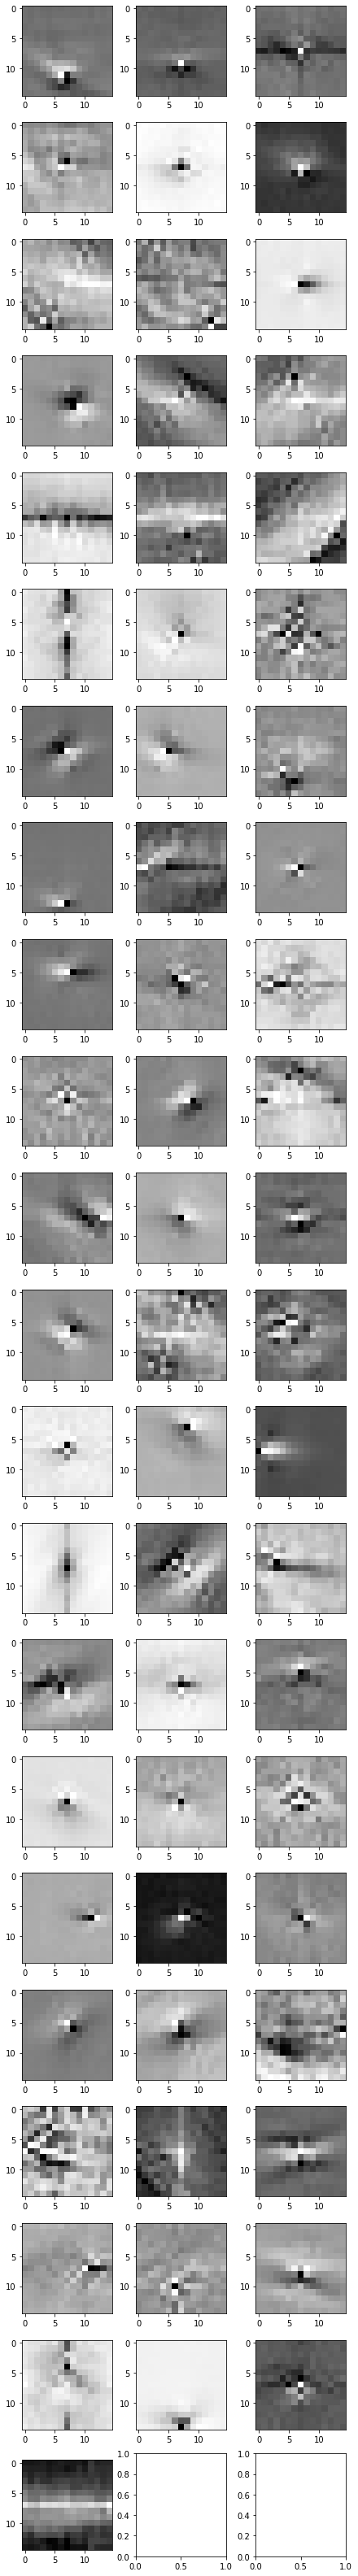

In [134]:
from feature_extraction.train_conv3d_sparse_model import plot_filters
filters_numpy = filters.detach().cpu().numpy()
plot_filters(filters_numpy)

In [ ]:
for i in range(64):
    for k in range(i+1,64):
        for j in range(k+1,64):
            for a in range(j+1,64):
                for b in range(a+1,64):
                    x = np.ones(64)
                    x[i] = 0
                    x[k] = 0
                    x[j] = 0
                    x[a] = 0
                    x[b] = 0

In [13]:
random.sample(range(100), 5)

TypeError: sample() got an unexpected keyword argument 'size'

In [17]:
x = 
                       
func_2 = lambda m: x[m]=0

SyntaxError: cannot assign to lambda (3437627256.py, line 3)

In [20]:
m=np.ones(64)
x = lambda a : return m[a] =0
print(x(5))

SyntaxError: cannot assign to lambda (3062601744.py, line 2)